In [1]:
import os
import sys

current_working_directory = os.getcwd()
project_directory = os.path.dirname(current_working_directory)
utils_path = os.path.join(project_directory, 'utils')
plotting_path = os.path.join(project_directory, 'plotting_templates')
if utils_path not in sys.path:
    sys.path.append(utils_path)

In [2]:
import time
import jax
jax.config.update("jax_enable_x64", True) # Enable 64-bit double precision

# Imports
import jax.numpy as jnp
from jax import random, vmap, scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utilities
from utils_DST import discrete_sine_transform, vmap_dst, vmap_compute_sine_coef
from utils_error import compute_2d_error
from utils_rough_pde import *
from utils_elliptic_coef import *
from utils_optim import kernel_linear_solver

from utils_rough_pde import vmap_root_interval
from scipy.special import roots_legendre

from utils_time_dependent import *


plt.style.use(plotting_path + '/plot_style-Examples_3d.txt')
width = 4
height = width * 3 / 4

In [3]:
def compute_1d_error(pred, u, x):
    norm_u = jnp.sqrt(scipy.integrate.trapezoid(u**2, x))
    norm_diff = jnp.sqrt(scipy.integrate.trapezoid((pred - u)**2, x))
    return norm_diff, norm_diff/norm_u

In [4]:
plt.style.use(plotting_path + '/plot_style-Examples_3d.txt')
width = 4
height = width * 3 / 4

# Benchmark: stochastic heat equation with spectral decomposition


We will solve

\begin{align}
&du = \Delta u dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

Let 
$$
u = \sum_{j=1}^\infty u_j(t)  \sqrt{2}\sin(j\pi x)
$$
Let 
\begin{align}
\phi_i &=  \sqrt{2}\sin(i\pi x) \\
-\Delta \phi_i &= j^2 \pi^2 \sqrt{2} \phi_j = \lambda_j \phi_j
\end{align}
Then the weak solution is given by 

$$
\langle du(t), \phi_i\rangle = - \langle u(t), -\Delta \phi_i  \rangle + \sigma \langle dW_t, \phi_i\rangle 
$$

Let 
$$
dW_t = \sum_{j=1} dB_j(t) \phi_j
$$
we BM in time, white noise is space. The above then becomes

$$
du^j = -\pi^2 j^2  u^jdt + \sigma dB^j(t)
$$
which is an OU process and can be simulated accurately.

We will use the explicit form 

$$
u^j_t = u_0 e^{-\pi^2 j^2 t} + \sigma  e^{-\pi^2 j^2 t}\int_{0}^t e^{\pi^2 j^2s}dW_s
$$

and discretize the integral 
$$
\int_{0}^t e^{\pi^2 j^2s}dW_s \approx \sum_{i=1}^N e^{\pi^2 j^2s_i}\Delta W_i
$$

We use this fine grid solution to measure the error on a coarser grid.

In [5]:
key = random.PRNGKey(12)


n_coef = 2**11
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1

# This is the initial condition
coef_g = -jnp.hstack([random.normal(key, shape= (n_coef,))])/(0.01*frequencies**(2+0.5)*jnp.pi**2  +1)
g_values = discrete_sine_transform(coef_g)

2048


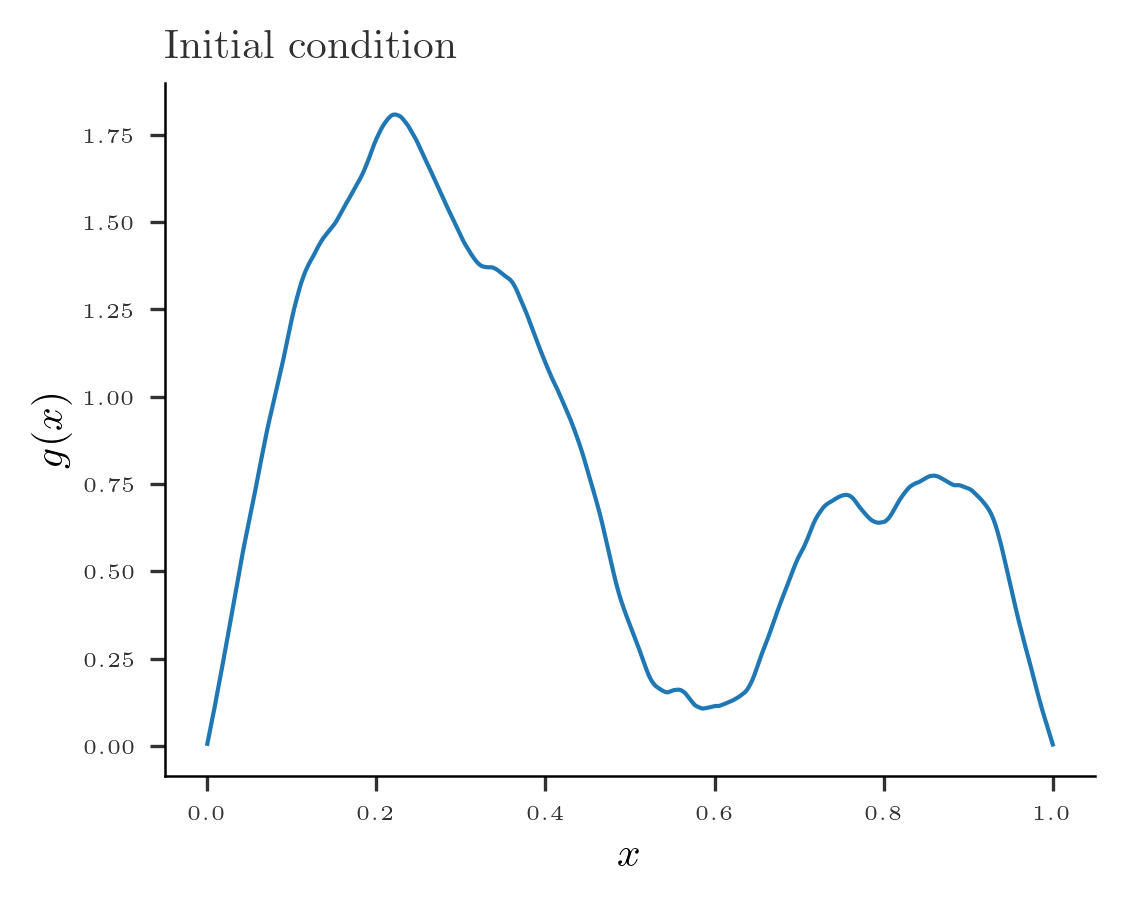

In [6]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [7]:
def convolve(K, Z):
    return scipy.signal.convolve(K, Z, mode='full')[:Z.shape[0]]

def OU_explicit(time_span, h, u_init, beta, sigma, BM):
    """
    time span should not contain the time 0.0
    """

    # Create the convolution kernel
    K = jnp.exp(-beta*time_span)
    u = u_init*jnp.exp(-beta*time_span) + sigma*jnp.sqrt(h)*convolve(K, BM)

    return jnp.hstack([u_init, u])

OU_system = vmap(OU_explicit, in_axes=(None, None, 0, 0, None, 0))

In [8]:
nu = 0.025
beta = nu*jnp.pi**2*jnp.arange(1, n_coef+1)**2

h_spectral  = 2**(-13)
T = T = 1.0 //h_spectral * h_spectral #h_spectral*2**13
print(T, h_spectral)
sigma = 0.1


time_span = jnp.arange(0, T +h_spectral, h_spectral)
key = random.PRNGKey(0)
BM = random.normal(key, (n_coef, time_span.shape[0]-1))

u_hist = OU_system(time_span[1:], h_spectral, coef_g, beta, sigma, BM)
u_values_T = vmap_dst(u_hist.T)

1.0 0.0001220703125


2025-01-14 16:45:16.978165: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng1{k2=4,k3=0} for conv (f64[1,2048,16383]{2,1,0}, u8[0]{0}) custom-call(f64[1,2048,8192]{2,1,0}, f64[2048,1,8192]{2,1,0}), window={size=8192 pad=8191_8191}, dim_labels=bf0_oi0->bf0, feature_group_count=2048, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
E0114 16:45:22.572606  548076 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0114 16:45:26.699050  548076 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-01-14 16:45:28.31

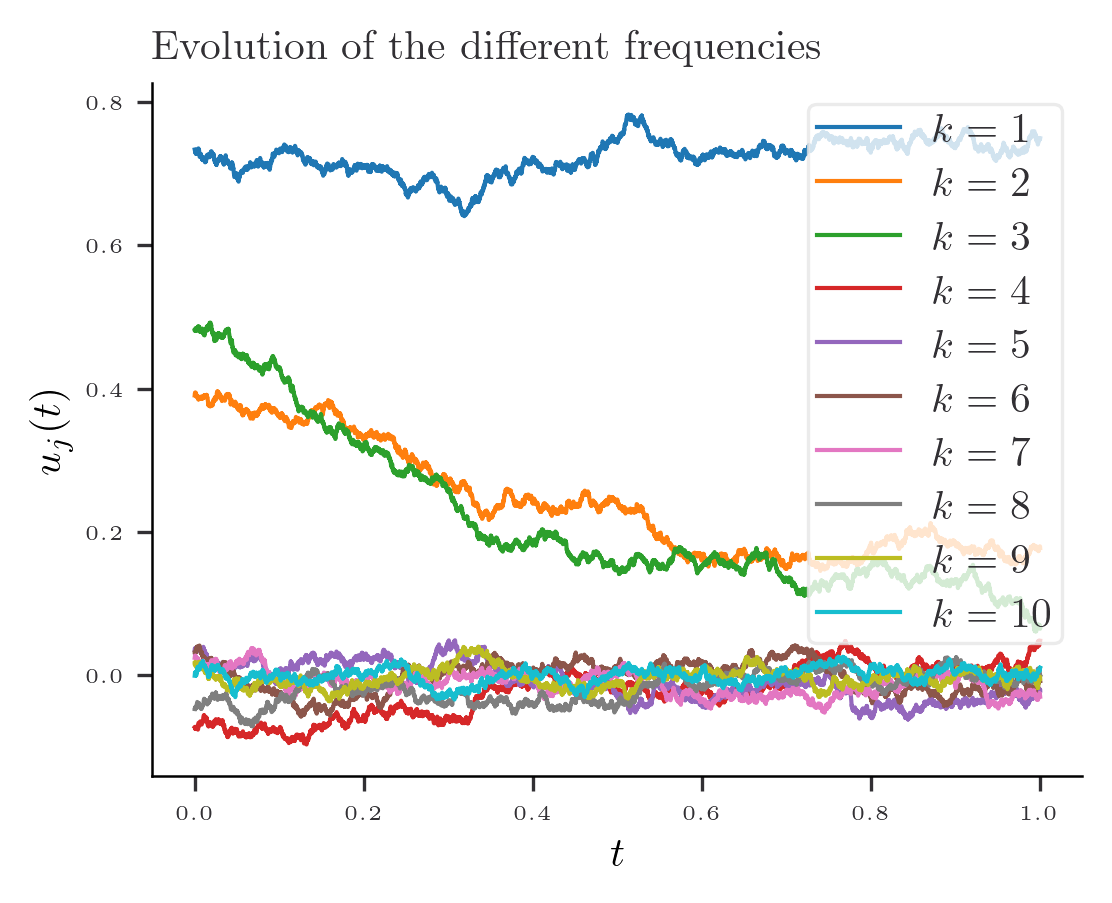

In [9]:
max_freq =10 
fig = plt.figure(figsize=(width, height))
for i in range(max_freq):
    plt.plot(time_span, u_hist[i], label=r"$k= {}$".format(i+1))
plt.xlabel(r"$t$")
plt.ylabel(r"$u_j(t)$")
plt.legend(loc = 'upper right')
plt.title(r"Evolution of the different frequencies")
plt.show()

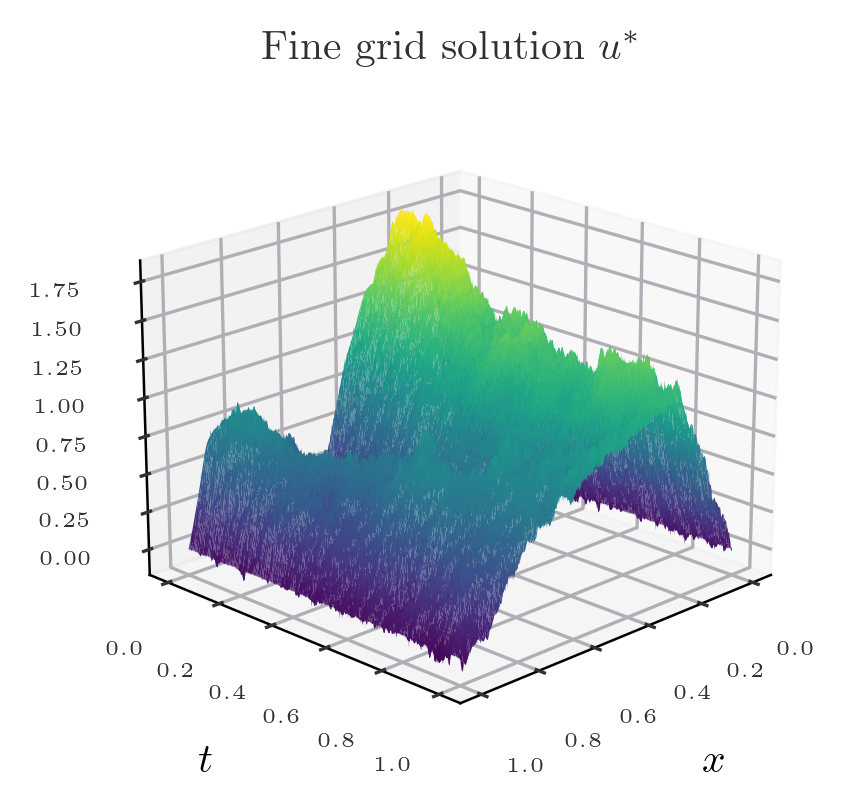

In [10]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span)
stride = 25
ax.plot_surface(X, time_grid, u_values_T,  cmap='viridis',  rstride=stride, cstride=stride)

#ax.plot_surface(X, time_grid, u_values_T,  cmap='viridis')
ax.set_title(r"Fine grid solution $u^*$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

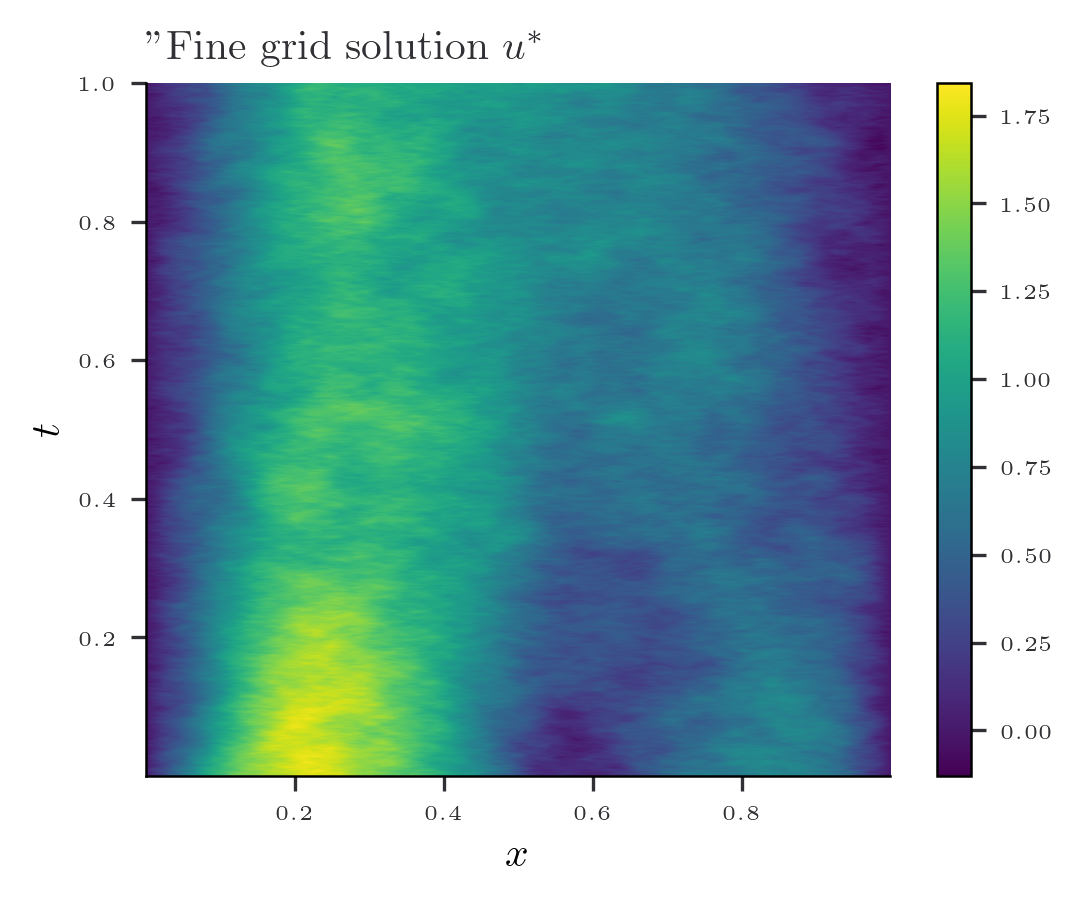

: 

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values_T[1:][::-1], cmap='viridis', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()], aspect='auto')

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'"Fine grid solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Solving time dependent systems

## Stochastic heat equation

We will solve 

\begin{align}
&du = \Delta u dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

where $\frac{dW_t}{dt}$ is space time white noise. We use an implicit EM method with step size $h$

\begin{align}
&u_0 = g(x) \\
&u_{n+1} = u_n + h \Delta u_{n+1} + \Delta W_n
\end{align}
where 
$$
\Delta W_n \sim \mathcal{N}(0, h I)
$$


Hence 
\begin{align}
&(-h \Delta + I )u_{n+1} = u_n + \Delta W_n\\
&u(t,0) = u(t, 1) = 0
\end{align}

At each step we solve

\begin{align}
[(-h \Delta + I )u_{n+1}, \psi] = [u_n,\psi] + \sqrt{h}[\Delta \xi_n, \psi]
\end{align}

### CFL condition

We need 

$$
\lambda_N h = C
$$
where $h$ is the timestep.
But

$$
\lambda_N = \nu\pi^2 N^2
$$

Hence we need 

$$
\nu\pi^2 N^2 h = C
$$

Hence we would like to choose

$$
N^2 h = \frac{1}{\nu\pi^2}
$$

In practice this is difficult to do.


In [15]:
coarse_factor = 4 # Coarsen the fine solution by a factor of 4
h = h_spectral*coarse_factor

time_span = jnp.arange(0, T+h, h)
time_span_spectral = jnp.arange(0, T+h_spectral, h_spectral) 
b =lambda x : jnp.ones_like(x)
length_scale = 0.1
cfl_factor = 5

print("We integrate the system with a time step of ", h)

We integrate the system with a time step of  0.00048828125


In [16]:
# Generate our Galerkin basis
n_intervals = int(jnp.sqrt(1/h)*cfl_factor) + 1#2**10
n_meas = n_intervals -1 # We do not include the boundary points

epsilon = (upper- lower)/n_intervals
centers = jnp.linspace(lower, upper, n_intervals + 1)
epsilon = (upper - lower)/n_intervals
epsilon_values  = jnp.ones(n_intervals)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T
print("We use {} measurements (tent functions spaced out by a factor h = {:.2e})".format(n_meas, epsilon))

We use 226 measurements (tent functions spaced out by a factor h = 4.41e-03)


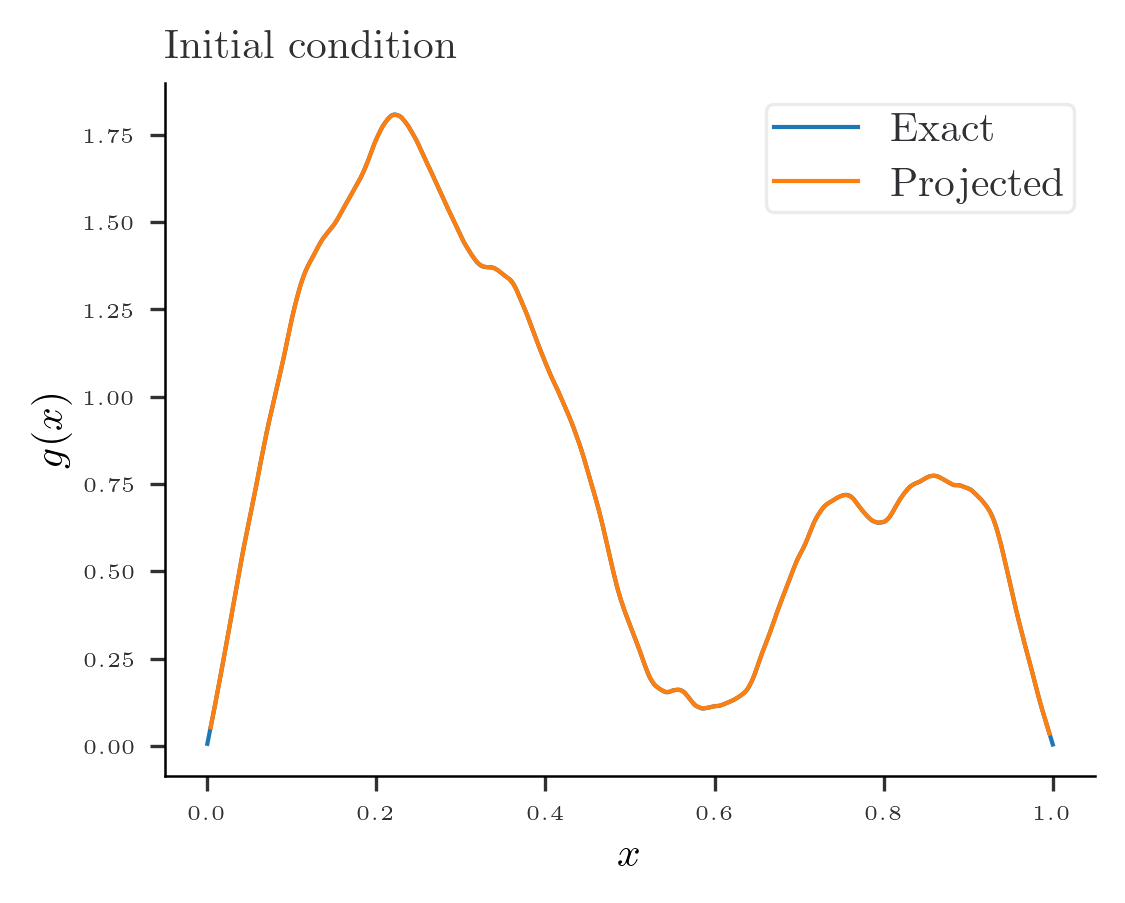

In [17]:
tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
g_tent = tent_proj_coef@coef_g # We can now project the initial condition onto the tent functions

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values, label = r"Exact")
plt.plot(centers[1:-1], g_tent, label = r"Projected")
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")
plt.legend(loc = 'upper right')

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [18]:
n_quad = 3
x_q, w_q = roots_legendre(n_quad)
# Quadrature node for the tent element
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))
# Quadrature node for the kernel
x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)
k_quad = []
for i in range(n_meas):
    k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
k_quad = jnp.array(k_quad)

root_b= b(k_quad)
element_quad = tent_element(x_element, normalization = 1.0)
tent_quad = jnp.hstack([element_quad, element_quad[::-1]])*jnp.hstack([w_element, w_element[::-1]])

# Coarsen the fine grid solution
BM_coarse = BM.reshape(n_coef, time_span_spectral[1:].shape[0] // coarse_factor, coarse_factor)
BM_coarse = jnp.sum(BM_coarse, axis = -1)
xi_tent_coarse = tent_proj_coef@BM_coarse*jnp.sqrt(h_spectral)
u_coarse = u_values_T[coarse_factor::coarse_factor]

In [19]:
linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)
start = time.time()
linear_solver.build_matrices(root_b)
linear_solver.create_K_psi()
linear_solver.create_K_eval(domain_finest)
end = time.time()
print("Time to build the matrices", jnp.round(end - start, 5))

Time to build the matrices 6.1519


In [20]:
start = time.time()
y, linear_solver, c_kernel_history= implicit_EM_solver(time_span[1:], h, linear_solver, g_tent, sigma,xi_tent_coarse)
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))
pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)

Time to integrate the system 3.04889


In [21]:
e, e_rel = compute_2d_error(pred_kernel, u_coarse, domain_finest, time_span[1:])
print("The L^2 error is {:.2e}. The relative L^2 error is {:.2e}".format(e, e_rel))
error_T, rel_error_T = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_coarse, domain_finest)

The L^2 error is 5.53e-03. The relative L^2 error is 6.84e-03


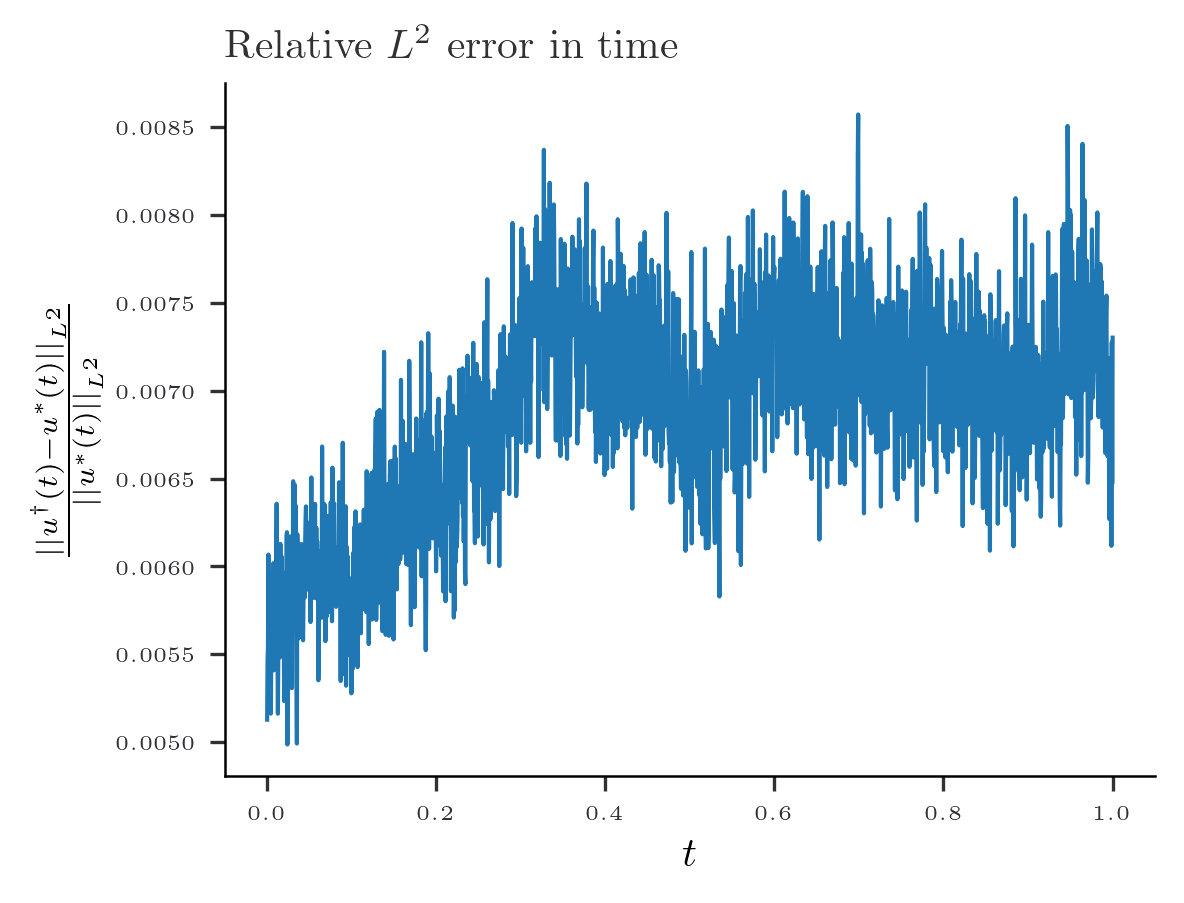

In [22]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(time_span[1:], rel_error_T)
plt.xlabel(r"$t$")
plt.ylabel(r"$\frac{||u^\dagger(t)-u^*(t) ||_{L^2}}{||u^*(t)||_{L^2}}$")
plt.title(r"Relative $L^2$ error in time")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

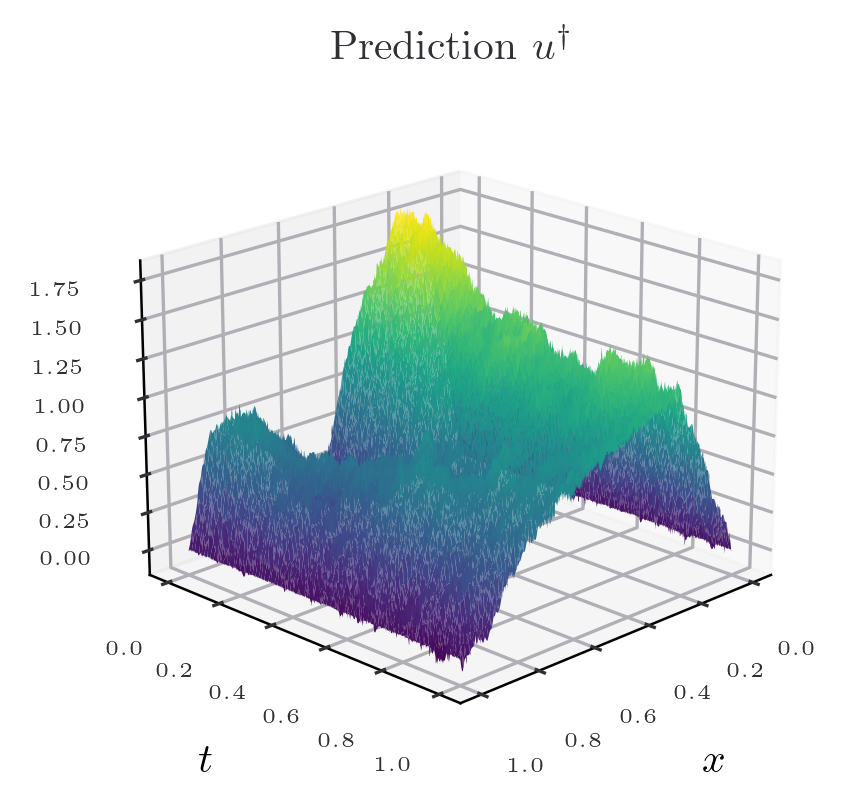

In [23]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span[1:])
stride = 25
ax.plot_surface(X, time_grid, pred_kernel,  cmap='viridis',  rstride=stride, cstride=stride)
ax.set_title(r"Prediction $u^\dagger$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

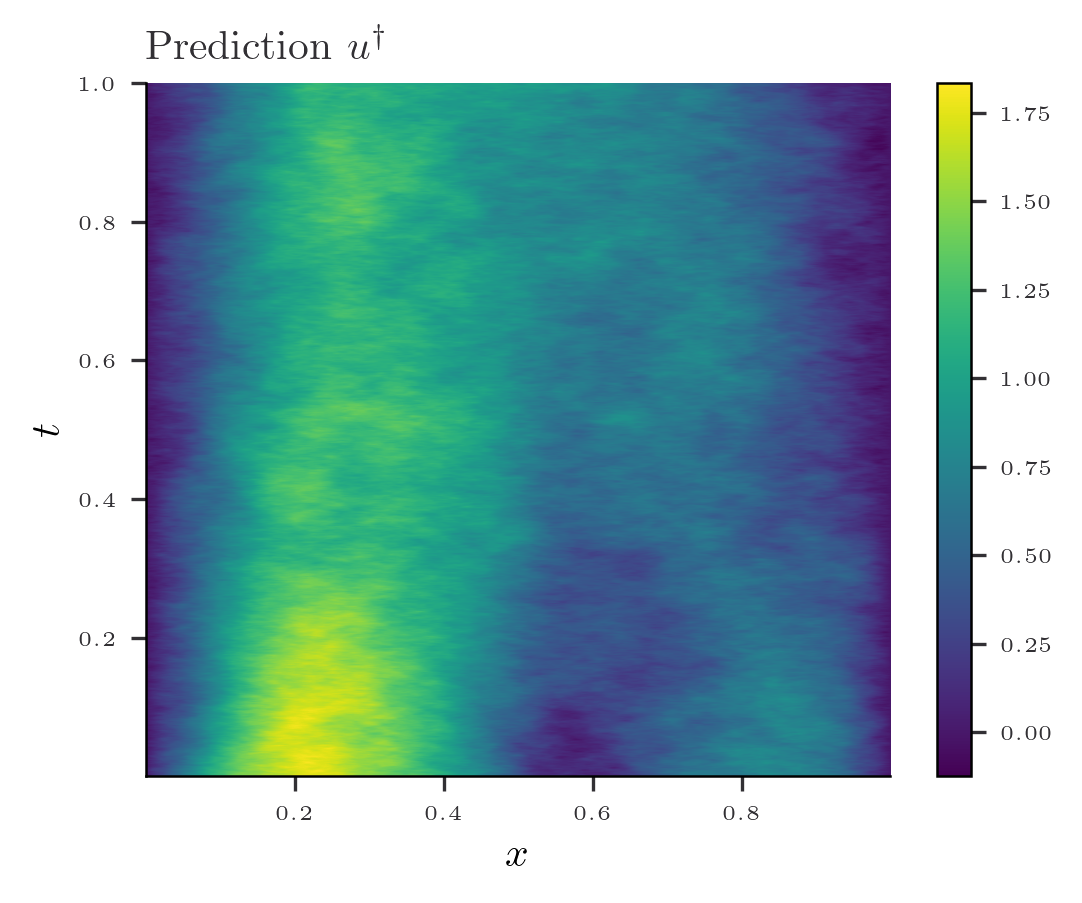

In [24]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_kernel[::-1], cmap='viridis', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()],  aspect='auto')

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Prediction $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

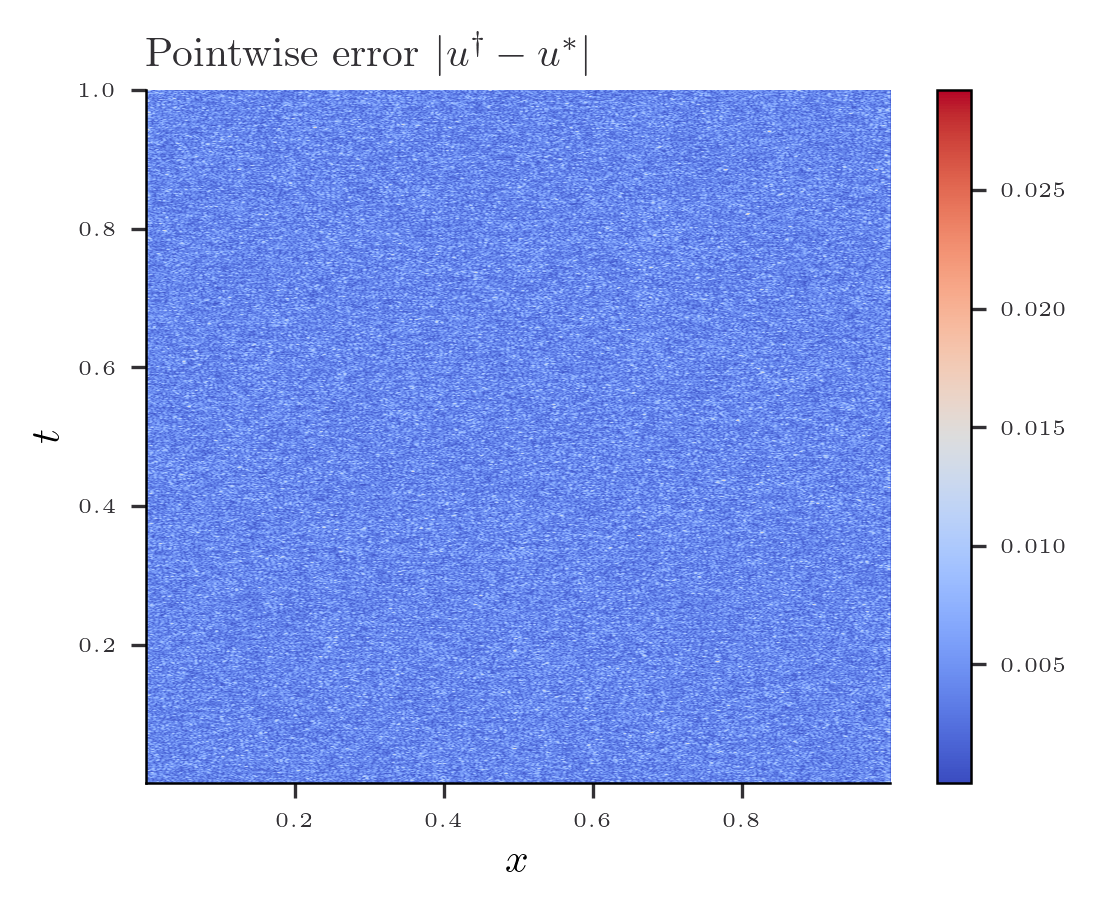

In [25]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_kernel - u_coarse)[::-1], cmap='coolwarm', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()],  aspect='auto')

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Computing error rates

In [26]:
h_list = jnp.array([2**i*h_spectral for i in range(2,13)])[::-1]
coarse_list = jnp.array([2**i for i in range(2, 10)])[::-1]

In [27]:

error_list = []
error_list_r = []
error_time = []
for coarse_factor in coarse_list:
    h = coarse_factor*h_spectral
    n_meas = int(jnp.sqrt(1/h)*cfl_factor)

    # Generate our Galerkin basis
    n_intervals = n_meas +1
    n_meas = n_intervals -1 # We do not include the boundary points

    epsilon = (upper- lower)/n_intervals
    centers = jnp.linspace(lower, upper, n_intervals + 1)
    epsilon = (upper - lower)/n_intervals
    epsilon_values  = jnp.ones(n_intervals)*epsilon
    intervals = jnp.array([centers[:-1], centers[1:]]).T

    # Quadrature node for the kernel
    x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)
    k_quad = []
    for i in range(n_meas):
        k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
    k_quad = jnp.array(k_quad)
    root_b= b(k_quad)

    # Project the initial condition on the Galerkin basis
    tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
    tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
    g_tent = tent_proj_coef@coef_g # We can now project the initial condition onto the tent functions

    # Coarsen the Wiener process
    BM_coarse = BM.reshape(n_coef, time_span_spectral[1:].shape[0] // coarse_factor, coarse_factor)
    BM_coarse = jnp.sum(BM_coarse, axis = -1)
    xi_tent_coarse = tent_proj_coef@BM_coarse*jnp.sqrt(h_spectral)

    linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)
    linear_solver.build_matrices(root_b)
    linear_solver.create_K_psi()
    linear_solver.create_K_eval(domain_finest)

    # Integrate
    time_span = jnp.arange(0, T+h, h)
    print(h, n_meas, time_span[1:].shape[0])
    y, linear_solver, c_kernel_history= implicit_EM_solver(time_span[1:], h, linear_solver, g_tent, sigma,xi_tent_coarse)

    pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)
    u_coarse = u_values_T[coarse_factor::coarse_factor]
    e, e_r = compute_2d_error(pred_kernel, u_coarse, domain_finest, time_span[1:])
    error_list.append(e)
    error_list_r.append(e_r)

    e_t , _  = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_coarse, domain_finest)
    error_time.append(e_t)

0.0625 20 16
0.03125 28 32
0.015625 40 64
0.0078125 56 128
0.00390625 80 256
0.001953125 113 512
0.0009765625 160 1024
0.00048828125 226 2048


In [28]:
error = jnp.array(error_list)
error_rel = jnp.array(error_list_r)

meas_list = []
for coarse_factor in coarse_list:
        h = coarse_factor*h_spectral
        n_meas = jnp.sqrt(1/h)*cfl_factor
        meas_list.append(T/h*n_meas)
meas_list = jnp.array(meas_list)

# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(meas_list)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  0.302


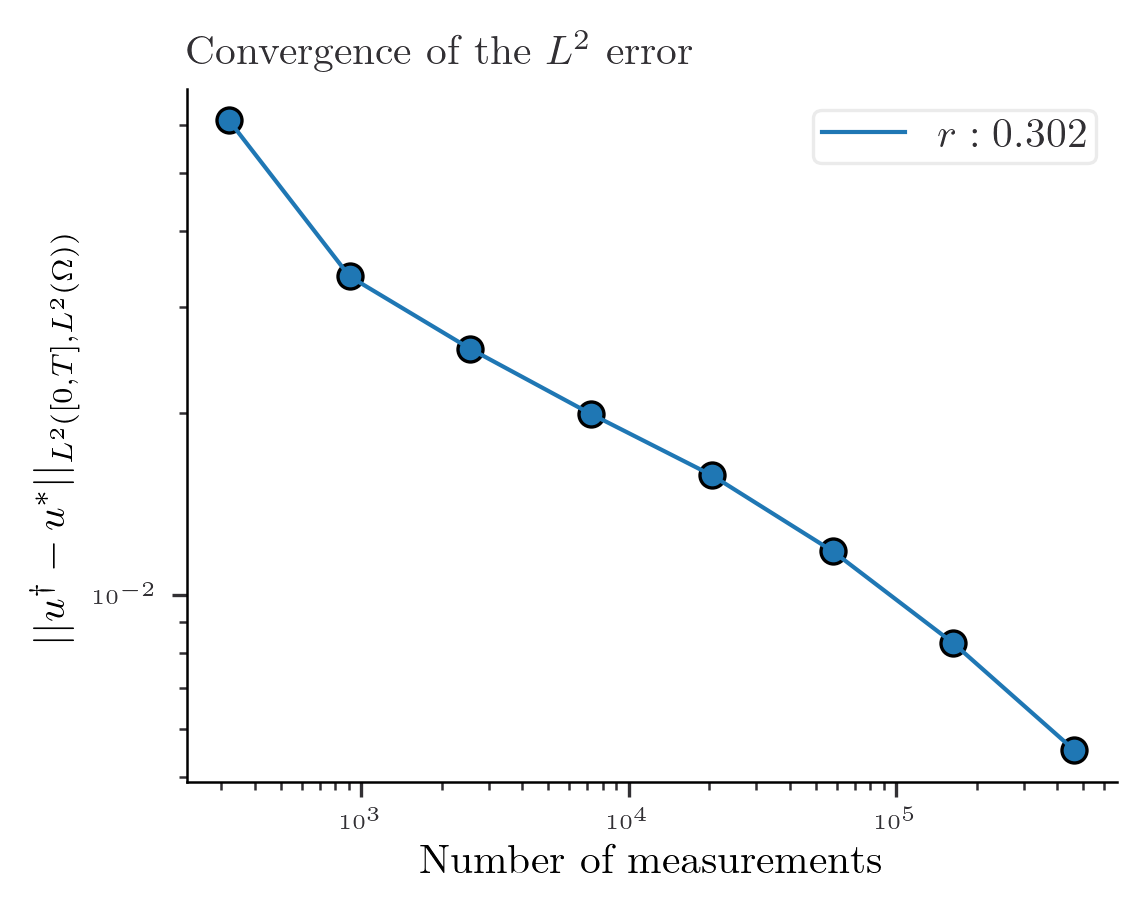

In [29]:
fig = plt.figure(figsize=(width, height))
plt.plot(meas_list, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(meas_list, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2([0, T], L^2(\Omega))}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()
